# Head pose

## Imports

In [173]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../DataLoader')

from Dataset import Dataset
import helpers
from helpers import imshow

from scipy.spatial.transform import Rotation as R

## Creation of a Dataset container

In [174]:
DATASET_PATH= '../Data'
dp = Dataset(path=DATASET_PATH)[0]

## Head coordinates system

World to image function definition

In [175]:
world_to_img = lambda x : helpers.world_to_img(x, dp.intrinsic_matrix, dp.extrinsic_matrix)
extrinsic_rotation = dp.extrinsic_matrix[:, :3]

Let's create a rotation matrix from the head Euler angles. Our convention is: **Pitch (x axis) -> Yaw (z axis) -> Roll (y axis)** and the rotation is **extrinsic**<br> 
We'll extract the head coordinates system (X, Y, Z vectors) from the matrix columns.

In [176]:
yaw, pitch, roll = dp.head_metadata.head_rotation

head_rotation_mat = R.from_euler('xzy', [pitch, yaw, roll], degrees=True).as_matrix()

Let's project the axes in the image plane. <br> 
To do so, we'll define the origin of the coordinates system as the point between the eyes. <br>

In [177]:

head_location_world = dp.head_metadata.head_six_dof.location
head_X_cam, head_Y_cam, head_Z_cam = (extrinsic_rotation @ head_rotation_mat).T

We can do the same for the look-at vector.

In [178]:

look_at_cam = extrinsic_rotation @ dp.head_metadata.head_six_dof.look_at_vector

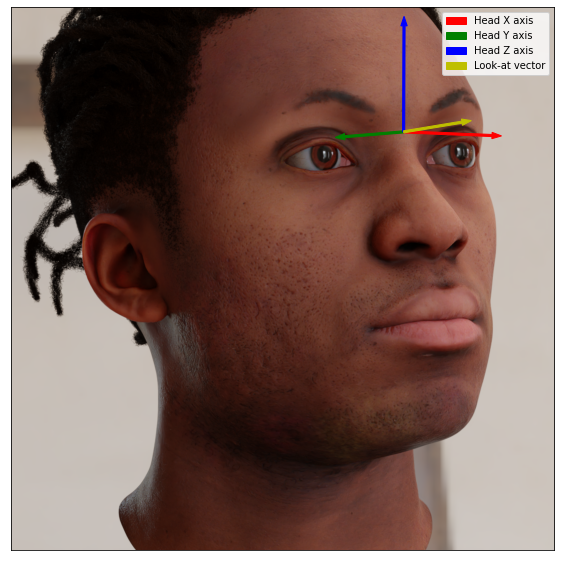

In [179]:

arrow_length = 200

head_center_cam = world_to_img(head_location_world)

imshow(dp.rgb_img)
plt.arrow(*head_center_cam, *(arrow_length * head_X_cam[:2]), color = 'r', label='Head X axis', width=4)
plt.arrow(*head_center_cam, *(arrow_length * head_Y_cam[:2]),  color = 'g', label='Head Y axis', width=4)
plt.arrow(*head_center_cam, *(arrow_length * head_Z_cam[:2]),  color = 'b', label='Head Z axis', width=4)
plt.arrow(*head_center_cam, *(arrow_length * look_at_cam[:2]),  color = 'y', label='Look-at vector', width=4)
plt.legend()